<a href="https://colab.research.google.com/github/mherskovitz/ML_Projects/blob/main/streak_mlb_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to the Baseball OBP Analysis Tool
This tool analyzes player On-Base Percentage (OBP) over time
Enter player names or 'quit' to exit

Enter player's first name (or 'quit' to exit): Juan
Enter player's last name: Soto

Fetching data for Juan Soto...
Gathering Player Data

Detailed events for first 5 days:

Date: 2024-02-25
Events:
- Event: home_run | Description: hit_into_play | Pitch: 4-Seam Fastball (FF) | Ball in play: fly_ball | Hit distance: 428.0 ft | Exit velocity: 110.1 mph | Launch angle: 22.0°
- Event: No event | Description: ball | Pitch: Changeup (CH)
- Event: walk | Description: ball | Pitch: 4-Seam Fastball (FF)
- Event: No event | Description: ball | Pitch: Curveball (CU)
- Event: field_out | Description: hit_into_play | Pitch: Curveball (CU) | Ball in play: ground_ball | Hit distance: 21.0 ft | Exit velocity: 90.8 mph | Launch angle: -7.0°
- Event: No event | Description: called_strike | Pitch: Curveball (CU)
- Event: No event | Description: foul | Pitch: Sweeper 

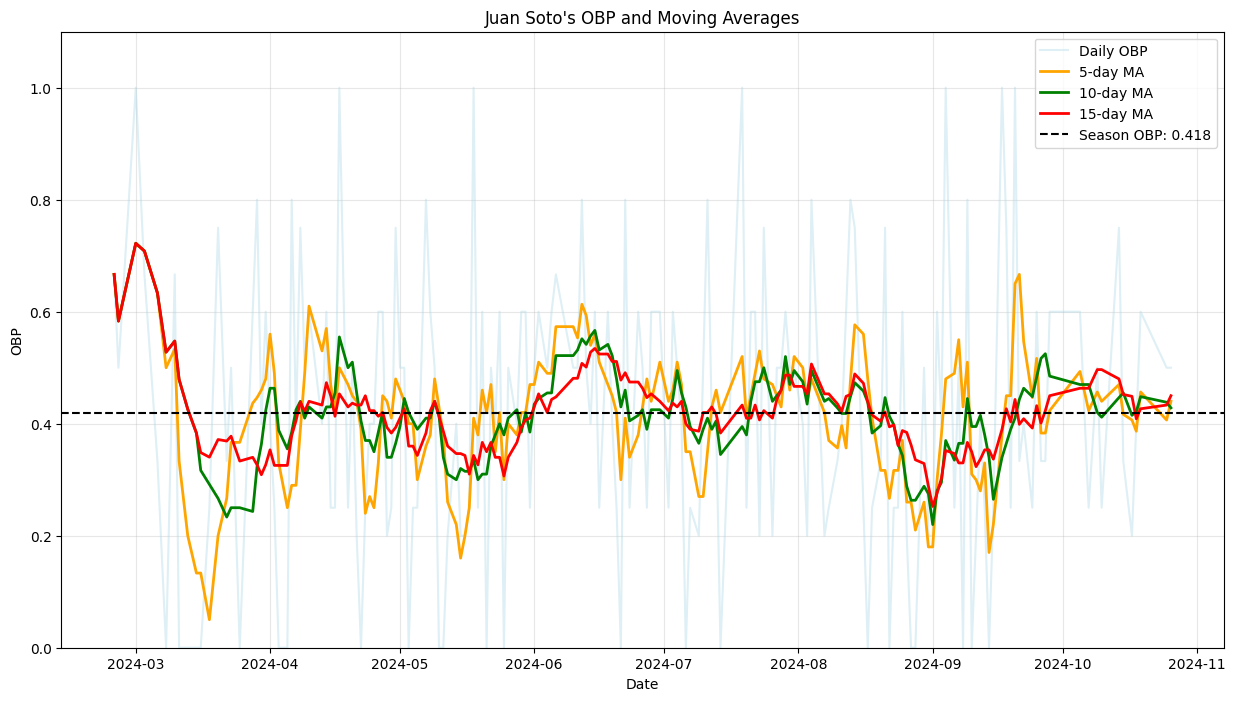


Latest Moving Averages for Juan Soto (as of 2024-10-26):
5-day OBP Moving Average: 0.440
10-day OBP Moving Average: 0.428
15-day OBP Moving Average: 0.450

Would you like to analyze another player? (yes/no): 
no

Thank you for using the baseball analysis tool!

Program finished. Thanks for using the Baseball OBP Analysis Tool!


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pybaseball import statcast_batter, playerid_lookup
from IPython.display import clear_output
import time

def get_player_id(first_name, last_name):
    """
    Look up player ID using first and last name
    """
    try:
        player_lookup = playerid_lookup(last_name, first_name)
        if player_lookup.empty:
            print(f"No player found with name {first_name} {last_name}")
            return None
        return player_lookup.iloc[-1]['key_mlbam']
    except Exception as e:
        print(f"Error looking up player: {e}")
        return None

def prepare_daily_stats(df):
    """
    Prepare daily statistics with detailed event information
    """
    if df is None or df.empty:
        return None

    df['game_date'] = pd.to_datetime(df['game_date'])

    # Print all events for first 5 days with additional details
    print("\nDetailed events for first 5 days:")
    first_5_days = df.sort_values('game_date').game_date.unique()[:5]

    # Define columns to display for each event
    detail_columns = [
        'events',
        'description',
        'pitch_type',
        'bb_type',              # Ball in play type
        'hit_location',
        'hit_distance_sc',      # Hit distance
        'launch_speed',         # Exit velocity
        'launch_angle',
        'pitch_name',
        'zone'
    ]

    for date in first_5_days:
        day_events = df[df['game_date'] == date]
        print(f"\nDate: {date.strftime('%Y-%m-%d')}")
        print("Events:")
        for idx, row in day_events.iterrows():
            # Build a detailed event description
            event_details = []

            # Always show the main event type (even if nan)
            event_details.append(f"Event: {row['events'] if pd.notna(row['events']) else 'No event'}")

            # Add the play description
            if pd.notna(row['description']):
                event_details.append(f"Description: {row['description']}")

            # Add pitch information
            if pd.notna(row['pitch_name']):
                pitch_info = f"Pitch: {row['pitch_name']}"
                if pd.notna(row['pitch_type']):
                    pitch_info += f" ({row['pitch_type']})"
                event_details.append(pitch_info)

            # Add ball in play information if available
            if pd.notna(row['bb_type']):
                event_details.append(f"Ball in play: {row['bb_type']}")

            # Add hit details if available
            if pd.notna(row['hit_distance_sc']):
                event_details.append(f"Hit distance: {row['hit_distance_sc']} ft")
            if pd.notna(row['launch_speed']):
                event_details.append(f"Exit velocity: {row['launch_speed']} mph")
            if pd.notna(row['launch_angle']):
                event_details.append(f"Launch angle: {row['launch_angle']}°")

            # Print all details for this event
            print(f"- " + " | ".join([detail for detail in event_details if detail]))

        print(f"Total events this day: {len(day_events)}")
        print("-" * 80)

    # Print overall event counts including non-null and null events
    print("\nAll unique events and their counts in dataset:")
    event_counts = df['events'].value_counts(dropna=False)
    print(event_counts)

    # Print the number of different pitch types
    print("\nPitch types used:")
    pitch_counts = df['pitch_type'].value_counts(dropna=False)
    print(pitch_counts)

    # Define at-bat events
    at_bat_events = [
        'single', 'double', 'triple', 'home_run',
        'strikeout', 'field_out', 'force_out', 'grounded_into_double_play',
        'fielders_choice', 'fielders_choice_out', 'double_play', 'triple_play',
        'fly_out', 'lineout', 'pop_out', 'groundout'
    ]

    # Create binary columns
    df['hits'] = df['events'].isin(['single', 'double', 'triple', 'home_run'])
    df['walks'] = df['events'].isin(['walk', 'intent_walk'])
    df['hit_by_pitch'] = df['events'] == 'hit_by_pitch'
    df['sac_fly'] = df['events'] == 'sac_fly'
    df['at_bat'] = df['events'].isin(at_bat_events)

    # Group by date and calculate daily statistics
    daily_stats = df.groupby('game_date').agg({
        'hits': 'sum',
        'walks': 'sum',
        'hit_by_pitch': 'sum',
        'sac_fly': 'sum',
        'at_bat': 'sum'
    }).reset_index()

    # Calculate OBP
    numerator = daily_stats['hits'] + daily_stats['walks'] + daily_stats['hit_by_pitch']
    denominator = daily_stats['at_bat'] + daily_stats['walks'] + daily_stats['hit_by_pitch'] + daily_stats['sac_fly']
    daily_stats['obp'] = numerator / denominator

    # Calculate moving averages
    daily_stats['obp_ma_5'] = daily_stats['obp'].rolling(window=5, min_periods=1).mean()
    daily_stats['obp_ma_10'] = daily_stats['obp'].rolling(window=10, min_periods=1).mean()
    daily_stats['obp_ma_15'] = daily_stats['obp'].rolling(window=15, min_periods=1).mean()

    return daily_stats

def plot_moving_averages(daily_stats, player_name):
    """
    Plot OBP with moving averages and additional statistics with dynamic y-axis limits
    """
    plt.figure(figsize=(15, 8))

    # Plot all lines
    plt.plot(daily_stats['game_date'], daily_stats['obp'], label='Daily OBP', alpha=0.4, color='lightblue')
    plt.plot(daily_stats['game_date'], daily_stats['obp_ma_5'], label='5-day MA', linewidth=2, color='orange')
    plt.plot(daily_stats['game_date'], daily_stats['obp_ma_10'], label='10-day MA', linewidth=2, color='green')
    plt.plot(daily_stats['game_date'], daily_stats['obp_ma_15'], label='15-day MA', linewidth=2, color='red')

    # Calculate season OBP
    season_obp = (daily_stats['hits'].sum() + daily_stats['walks'].sum() + daily_stats['hit_by_pitch'].sum()) / \
                 (daily_stats['at_bat'].sum() + daily_stats['walks'].sum() + daily_stats['hit_by_pitch'].sum() + daily_stats['sac_fly'].sum())

    # Add season OBP as horizontal line
    plt.axhline(y=season_obp, color='black', linestyle='--', label=f'Season OBP: {season_obp:.3f}')

    # Calculate the maximum value across all OBP metrics
    max_obp = max(
        daily_stats['obp'].max(),
        daily_stats['obp_ma_5'].max(),
        daily_stats['obp_ma_10'].max(),
        daily_stats['obp_ma_15'].max()
    )

    # Set dynamic y-axis limits with some padding
    plt.ylim(0, max_obp * 1.1)  # Add 10% padding above the maximum value

    plt.title(f"{player_name}'s OBP and Moving Averages")
    plt.xlabel('Date')
    plt.ylabel('OBP')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

def analyze_player(first_name, last_name):
    """
    Analyze a single player's statistics
    """
    player_id = get_player_id(first_name, last_name)

    if player_id is None:
        return

    player_name = f"{first_name} {last_name}"

    # Date range for analysis
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

    print(f"\nFetching data for {player_name}...")
    # Fetch player data
    raw_data = fetch_player_data(start_date, end_date, player_id)

    if raw_data is not None:
        daily_stats = prepare_daily_stats(raw_data)

        if daily_stats is not None:
            # Plot moving averages
            plot_moving_averages(daily_stats, player_name)

            # Print current moving averages
            latest_date = daily_stats['game_date'].max()
            latest_stats = daily_stats[daily_stats['game_date'] == latest_date].iloc[0]
            print(f"\nLatest Moving Averages for {player_name} (as of {latest_date.strftime('%Y-%m-%d')}):")
            print(f"5-day OBP Moving Average: {latest_stats['obp_ma_5']:.3f}")
            print(f"10-day OBP Moving Average: {latest_stats['obp_ma_10']:.3f}")
            print(f"15-day OBP Moving Average: {latest_stats['obp_ma_15']:.3f}")
        else:
            print("Error: Could not prepare daily statistics")
    else:
        print("Error: Could not fetch player data")
def fetch_player_data(start_date, end_date, player_id):
    """
    Fetch player data for the specified date range
    """
    try:
        # Get statcast data for the specified player and date range
        data = statcast_batter(start_date, end_date, player_id)
        if data is None or data.empty:
            print(f"No data found for player ID {player_id} in date range {start_date} to {end_date}")
            return None
        return data
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# Main program execution
# Main program execution
def main():
    print("Welcome to the Baseball OBP Analysis Tool")
    print("=" * 40)
    print("This tool analyzes player On-Base Percentage (OBP) over time")
    print("Enter player names or 'quit' to exit")
    print("=" * 40)

    analyzing = True
    while analyzing:
        try:
            # Get player name
            first_name = input("\nEnter player's first name (or 'quit' to exit): ")
            if first_name.lower() == 'quit':
                break

            last_name = input("Enter player's last name: ")

            # Analyze the player
            analyze_player(first_name, last_name)

            # Give user time to see the results
            time.sleep(2)

            # Ask about analyzing another player
            while True:
                print("\nWould you like to analyze another player? (yes/no): ")
                another = input().lower().strip()
                if another in ['yes', 'no']:
                    break
                print("Please enter 'yes' or 'no'")

            if another == 'no':
                analyzing = False
                print("\nThank you for using the baseball analysis tool!")
                break
            else:
                # Start fresh for next player without clearing screen
                print("\n" + "="*40)
                print("Baseball Player OBP Analysis")
                print("-" * 30)
                print("Enter information for the next player:")
                plt.close('all')  # Close any open plots

        except Exception as e:
            print(f"\nAn error occurred: {e}")
            print("Please try again with a different player.")
            time.sleep(2)

    print("\nProgram finished. Thanks for using the Baseball OBP Analysis Tool!")

# Run the main program
if __name__ == "__main__":
    main()